In [1]:
import numpy as np
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import joblib

In [4]:
# Read word embedding

In [7]:
words, vectors = [], []
with open("data/metadata_norm_sentence_length_6_256_v2.tsv", mode="r") as words_file, \
open("data/vectors_norm_sentence_length_6_256_v2.tsv", mode="r") as vectors_file:
    for word in words_file:
        if not word[:-1]:
            continue
        words.append(word[:-1])
    for vector in vectors_file:
        if not vector[:-1]:
            continue
        vectors.append([float(vec) for vec in vector[:-1].split()]) 

embedding = {word: np.array(vectors[idx]) for idx, word in enumerate(words)}

In [5]:
# Define variables

In [13]:
UNK = '[UNK]'
sentence_length = 8
embedding_vectors_dim = 256

In [57]:
# Read dataset from file, transform sentences to embedding and get dictionary 
# of the form: 
# {target_class_1: [embeddings_sentence_1, embeddings_sentence_2, ...], target_class_2: [...], ...}. 
# For getting vector from senetence we get element-wise average of words embedding: 
# embeddings_sentence_1 = (embedding_word_1 + embedding_word_2 +...)/number_of_words_in_the_sentence_1

In [15]:
result = {}
samples = {}
filename = "data/multiclassification_dataset_new.csv"
with open(filename, mode="r") as file:
    for line in file:
        sample, class_ = line[:-1].split(";")
        class_ = "_".join(class_.split())
        if class_ not in result:
            result[class_] = []
            samples[class_] = []
        samples[class_].append(sample)
        sentence_vector = np.zeros((embedding_vectors_dim,))
        words = sample.strip().split()[:sentence_length]
        for word in words:
            sentence_vector += embedding[word] if word in embedding else embedding[UNK]
        if words:
            sentence_vector /= len(words)        
            result[class_].append(sentence_vector)

In [16]:
result.keys()

dict_keys(['connect_to_inet', 'no_internet', 'finance', 'support', 'consult'])

In [58]:
len(result['connect_to_inet'][0])

256

In [22]:
for k,v in result.items():
    print(f"{k}: {(len(v))}")

connect_to_inet: 593
no_internet: 511
finance: 1848
support: 1871
consult: 2163


In [59]:
# Define X and y from result

In [23]:
X, y = [], []
for class_, samples in result.items():
    for sample in samples:
        X.append(sample)
        y.append(class_)

In [60]:
# Split to train and test

In [24]:
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### SVM

In [61]:
# Choose the best parameters value with gridsearch

In [25]:
param_grid =  {
    'C': [1, 5, 10], 
    'gamma': ['scale', 'auto'], 
    'kernel': ['rbf', 'sigmoid'], 
    'class_weight': ['balanced', None],
}
svc = SVC()
clf = GridSearchCV(svc, param_grid).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9055793991416309

In [26]:
clf.best_estimator_.get_params()

{'C': 5,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [27]:
clf0 = clf.best_estimator_

In [32]:
y_test_pred = clf0.predict(X_test)

In [62]:
# Print base metrics

In [33]:
print(metrics.classification_report(y_test_pred, y_test))

                 precision    recall  f1-score   support

connect_to_inet       0.87      0.85      0.86       116
        consult       0.88      0.92      0.90       433
        finance       0.95      0.90      0.92       373
    no_internet       0.78      0.85      0.81        80
        support       0.93      0.93      0.93       396

       accuracy                           0.91      1398
      macro avg       0.88      0.89      0.89      1398
   weighted avg       0.91      0.91      0.91      1398



In [63]:
# Print confusion matrix to see the most problematic classes

In [34]:
def conf_matrix(y_true, y_pred, keys):
    cm = confusion_matrix(y_true, y_pred, labels=list(keys))
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(keys))
    disp.plot(xticks_rotation="vertical", ax=ax)

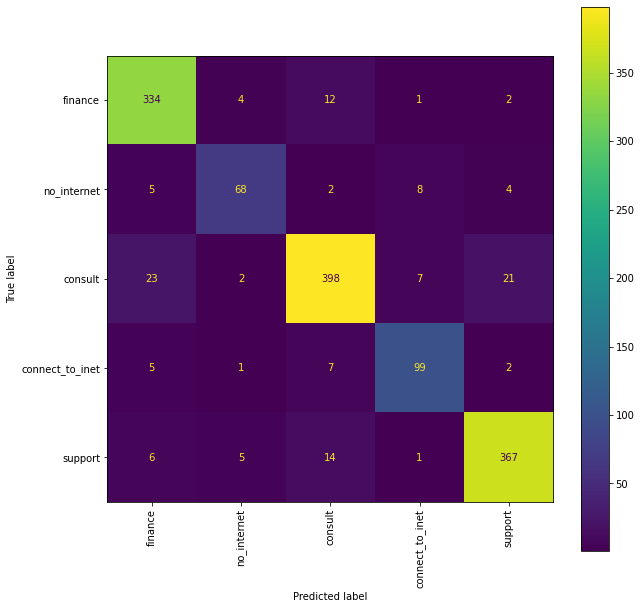

In [35]:
conf_matrix(y_test, y_test_pred, set(y_test_pred))

In [64]:
# The most problematic class is 'consult'. On 21 samples we made a mistake by predicting class 'support' and 
# on 23 samples we made a mistake by predicting class 'finance'. It may be due not-so-good dataset that has 
# human errors. 

In [65]:
# Save the model for future using

In [37]:
filename = 'multiclassification_5_category_update_256.sav'
joblib.dump(clf0, filename)

['multiclassification_5_category_update_256.sav']